## CNN - Movie Genre Classification

CST - 435 <br>
Grand Canyon University<br>
Created By: Caleb Klinger, Kyungchan Im<br>
Professor: Isac Artzi

We are going to perform a Convolutionary Neural Network to predict the genre based off from the poster image. <br> We will perform image classification by training the model by its categories. This dataset is from Kaggle, but originally from 

Wei-Ta Chu and Hung-Jui Guo, “Movie Genre Classification based on Poster Images with Deep Neural Networks,” Proceedings of International Workshop on Multimodal Understanding of Social, Affective and Subjective Attributes, pp. 39-45, 2017. (in conjunction with ACM Multimedia 2017).

### Import Necessary Packages
---

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,BatchNormalization,Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Download dataset on https://www.kaggle.com/datasets/raman77768/movie-classifier

# Load the dataset
movies = pd.read_csv('movie_dataset/train.csv') # Dataset containing genres with movie poster IDs

In [3]:
# Check the basic information of the dataset
movies.head()

,Id,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,N/A,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,tt0086425,"['Comedy', 'Drama']",0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,tt0085549,"['Drama', 'Romance', 'Music']",0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,tt0086465,['Comedy'],0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0086567,"['Sci-Fi', 'Thriller']",0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,tt0086034,"['Action', 'Adventure', 'Thriller']",1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Normalizing Dataset

In [4]:
X = [] # Image data
# movies.shape[0] = number of iteration required to convert all pictures to numpy array

# Normalizing the images to pixel values
for i in tqdm(range(movies.shape[0])):
    path = 'movie_dataset/Images/' + movies['Id'][i] + '.jpg'

    # Load the image and resize it to 350x350 pixels
    image = load_img(path, target_size=(350,350,3))

    # Convert the image to array
    image_array = img_to_array(image)

    # Normalize the image
    image_array = image_array/255

    # Append the image to the list
    X.append(np.array(image_array))

# Convert the list to numpy array
X = np.array(X).astype('float32')

100%|██████████| 7254/7254 [00:17<00:00, 410.55it/s]


---

In [5]:
X.shape

(7254, 350, 350, 3)

In [6]:
movies.columns

Index(['Id', 'Genre', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'N/A', 'News',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western'],
      dtype='object')

In [7]:
y = movies.drop(['Id','Genre'],axis=1)
y = y.to_numpy()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=32)

In [13]:
# Using a pre-trained model
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers

base_model = VGG16(input_shape=(350, 350, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(25, activation='sigmoid')
])

# Using learning rate scheduling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
optimizer = Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 10, 10, 512)       14714688  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               13107456  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 25)                6425      
                                                                 
Total params: 27,828,569
Trainable params: 13,113,881
Non-trainable params: 14,714,688
_________________________________________________________________


In [15]:
# Apply Tensorboard for further analysis
from tensorflow.keras.callbacks import TensorBoard
from datetime import datetime

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [16]:
# Save the best model with ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint

# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [17]:
# use this for general model
history = model.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test), batch_size=32, callbacks=[tensorboard_callback, checkpoint, reduce_lr])

Epoch 1/5
182/182 [==============================] - 645s 4s/step - loss: 0.3048 - accuracy: 0.2568 - val_loss: 0.2309 - val_accuracy: 0.3625 - lr: 1.0000e-04
Epoch 2/5
182/182 [==============================] - 648s 4s/step - loss: 0.2545 - accuracy: 0.3267 - val_loss: 0.2292 - val_accuracy: 0.3501 - lr: 1.0000e-04
Epoch 3/5
182/182 [==============================] - 646s 4s/step - loss: 0.2293 - accuracy: 0.3657 - val_loss: 0.2257 - val_accuracy: 0.3398 - lr: 1.0000e-04
Epoch 4/5
182/182 [==============================] - 644s 4s/step - loss: 0.2111 - accuracy: 0.3876 - val_loss: 0.2262 - val_accuracy: 0.3660 - lr: 1.0000e-04
Epoch 5/5
182/182 [==============================] - 641s 4s/step - loss: 0.1963 - accuracy: 0.4075 - val_loss: 0.2281 - val_accuracy: 0.3666 - lr: 1.0000e-04


---

### Use Tensorboard and Graph For Analysis

In [35]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 22668), started 0:11:39 ago. (Use '!kill 22668' to kill it.)

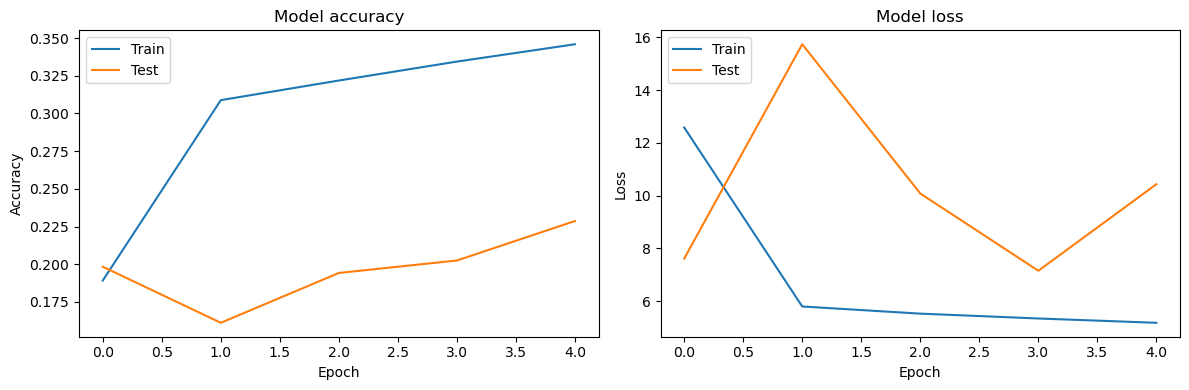

In [36]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


---
Save or Load the model

In [ ]:
# Comment out when you want to load the model
# model = tf.keras.models.load_model('movie_classifier.h5')

In [ ]:
model.save('movie_classifier_1.h5')

c:\Users\VRLab\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


---

## Test Evaluation

In [37]:
score = model.evaluate(X_test, y_test, verbose = 0 )
print("Test Score: ", score[0])
print("Test accuracy: ", score[1])

Test Score:  10.431268692016602
Test accuracy:  0.22865013778209686


### Testing

1/1 [==============================] - 0s 95ms/step
Drama
Adventure
Action


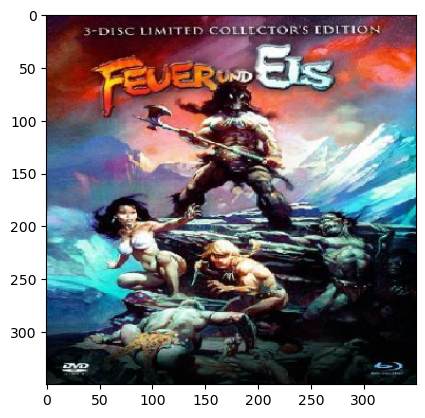

In [38]:
img = load_img('movie_dataset/Images/tt0085542.jpg',target_size=(350,350,3))
plt.imshow(img)
img = img_to_array(img)
img = img/255.0
img = img.reshape(1,350,350,3)
classes = movies.columns[2:]
y_pred = model.predict(img)
top3=np.argsort(y_pred[0])[:-4:-1]
for i in range(3):
    print(classes[top3[i]])

In [39]:
movies[movies['Id'] == 'tt0085542']

,Id,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,N/A,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
108,tt0085542,"['Animation', 'Fantasy', 'Adventure']",0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
